### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
pwd

'/home/MLOps_Assignment/02_training_pipeline/notebooks'

In [3]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *

 ### 2 Reading Data

In [4]:
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
%time
dataset = pd.read_csv('Data/cleaned_data.csv')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


In [5]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [6]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

In [7]:
dataset.shape

(238964, 12)

### 3 Setting up Environment: 

In [8]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebooks/' location

import sqlite3
from sqlite3 import Error

def create_sqlit_connection(db_path,db_file):
    """ create a database connection to a SQLite database """
    conn = None
    # opening the conncetion for creating the sqlite db
    try:
        conn = sqlite3.connect(db_path+db_file)
        print(sqlite3.version)
    # return an error if connection not established
    except Error as e:
        print(e)
    # closing the connection once the database is created
    finally:
        if conn:
            conn.close()

In [9]:
create_sqlit_connection("/home/MLOps_Assignment/02_training_pipeline/notebooks/","lead_scoring_model_experimentation.db")

2.6.0


'''
Now you need to start the MLflow server in a new terminal. 
Note: Before you start the MLflow server, create a folder named mlruns in the assignment directory.
Now you need to run the command to start MLflow server such that:
1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.
2. mlruns folder is used as an artifact directory. 
3. The server runs on the port 6006.

The steps to do so are as follows:
Open a new terminal.
Then go to the Assignment directory using the cd command. Type the command: cd Assignment/
Create a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns
Then, type the following command to start the MLflow server: 
mlflow server --backend-store-uri='sqlite:////home/MLOps_Assignment/02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0
'''

In [10]:
#mlflow server --backend-store-uri='sqlite:////home/MLOps_Assignment/02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0

In [11]:
# Once, your server is successfully running, create a mlflow tracking uri at "http://0.0.0.0:6006"
mlflow.set_tracking_uri("http://0.0.0.0:6006")

In [14]:
dataset['city_tier'] = dataset.city_tier.astype('category')

In [15]:
ONE_HOT_ENCODED_FEATURES = ['city_tier_1.0', 'city_tier_2.0', 'city_tier_3.0', 'first_platform_c_Level0', 'first_platform_c_Level1',
       'first_platform_c_Level2', 'first_platform_c_Level3', 'first_platform_c_Level7', 'first_platform_c_Level8',
       'first_platform_c_others', 'first_utm_medium_c_Level0', 'first_utm_medium_c_Level10', 'first_utm_medium_c_Level11',
       'first_utm_medium_c_Level13', 'first_utm_medium_c_Level15', 'first_utm_medium_c_Level16', 'first_utm_medium_c_Level2',
       'first_utm_medium_c_Level20', 'first_utm_medium_c_Level26', 'first_utm_medium_c_Level3', 'first_utm_medium_c_Level30',
       'first_utm_medium_c_Level33', 'first_utm_medium_c_Level4', 'first_utm_medium_c_Level43', 'first_utm_medium_c_Level5',
       'first_utm_medium_c_Level6', 'first_utm_medium_c_Level8', 'first_utm_medium_c_Level9', 'first_utm_medium_c_others',
       'first_utm_source_c_Level0', 'first_utm_source_c_Level14', 'first_utm_source_c_Level16', 'first_utm_source_c_Level2',
       'first_utm_source_c_Level4', 'first_utm_source_c_Level5', 'first_utm_source_c_Level6', 'first_utm_source_c_Level7',
       'first_utm_source_c_others', 'total_leads_droppped', 'referred_lead', 
       'assistance_interaction', 'career_interaction', 'payment_interaction', 'social_interaction',
       'syllabus_interaction', 'app_complete_flag']

In [16]:
FEATURES_TO_ENCODE = ['city_tier', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']

In [17]:
encoded_df = pd.DataFrame(columns= ONE_HOT_ENCODED_FEATURES) # from constants.py
placeholder_df = pd.DataFrame()

In [18]:
# One-Hot Encoding using get_dummies for the specified categorical features
for f in FEATURES_TO_ENCODE:
    if(f in dataset.columns):
        encoded = pd.get_dummies(dataset[f])
        encoded = encoded.add_prefix(f + '_')
        placeholder_df = pd.concat([placeholder_df, encoded], axis=1)
    else:
        print('Feature not found')

In [19]:
placeholder_df.columns

Index(['city_tier_1.0', 'city_tier_2.0', 'city_tier_3.0',
       'first_platform_c_Level0', 'first_platform_c_Level1',
       'first_platform_c_Level2', 'first_platform_c_Level3',
       'first_platform_c_Level7', 'first_platform_c_Level8',
       'first_platform_c_others', 'first_utm_medium_c_Level0',
       'first_utm_medium_c_Level10', 'first_utm_medium_c_Level11',
       'first_utm_medium_c_Level13', 'first_utm_medium_c_Level15',
       'first_utm_medium_c_Level16', 'first_utm_medium_c_Level2',
       'first_utm_medium_c_Level20', 'first_utm_medium_c_Level26',
       'first_utm_medium_c_Level3', 'first_utm_medium_c_Level30',
       'first_utm_medium_c_Level33', 'first_utm_medium_c_Level4',
       'first_utm_medium_c_Level43', 'first_utm_medium_c_Level5',
       'first_utm_medium_c_Level6', 'first_utm_medium_c_Level8',
       'first_utm_medium_c_Level9', 'first_utm_medium_c_others',
       'first_utm_source_c_Level0', 'first_utm_source_c_Level14',
       'first_utm_source_c_Level16'

In [20]:
# Implement these steps to prevent dimension mismatch during inference
for feature in encoded_df.columns:
    if feature in dataset.columns:
        encoded_df[feature] = dataset[feature]
    if feature in placeholder_df.columns:
        encoded_df[feature] = placeholder_df[feature]
# fill all null values
encoded_df.fillna(0, inplace=True)

In [21]:
encoded_df.head()

,city_tier_1.0,city_tier_2.0,city_tier_3.0,first_platform_c_Level0,first_platform_c_Level1,first_platform_c_Level2,first_platform_c_Level3,first_platform_c_Level7,first_platform_c_Level8,first_platform_c_others,...,first_utm_source_c_Level7,first_utm_source_c_others,total_leads_droppped,referred_lead,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction,app_complete_flag
0,1,0,0,1,0,0,0,0,0,0,...,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0,1,0,0,0,0,1,0,0,0,...,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1,0,0,0,0,0,1,0,0,0,...,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1,0,0,0,1,0,0,0,0,0,...,0,1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [34]:
encoded_df.columns

Index(['city_tier_1.0', 'city_tier_2.0', 'city_tier_3.0',
       'first_platform_c_Level0', 'first_platform_c_Level1',
       'first_platform_c_Level2', 'first_platform_c_Level3',
       'first_platform_c_Level7', 'first_platform_c_Level8',
       'first_platform_c_others', 'first_utm_medium_c_Level0',
       'first_utm_medium_c_Level10', 'first_utm_medium_c_Level11',
       'first_utm_medium_c_Level13', 'first_utm_medium_c_Level15',
       'first_utm_medium_c_Level16', 'first_utm_medium_c_Level2',
       'first_utm_medium_c_Level20', 'first_utm_medium_c_Level26',
       'first_utm_medium_c_Level3', 'first_utm_medium_c_Level30',
       'first_utm_medium_c_Level33', 'first_utm_medium_c_Level4',
       'first_utm_medium_c_Level43', 'first_utm_medium_c_Level5',
       'first_utm_medium_c_Level6', 'first_utm_medium_c_Level8',
       'first_utm_medium_c_Level9', 'first_utm_medium_c_others',
       'first_utm_source_c_Level0', 'first_utm_source_c_Level14',
       'first_utm_source_c_Level16'

In [22]:
target_df = dataset[['app_complete_flag']]

In [23]:
target_df.head()

,app_complete_flag
0,1
1,1
2,1
3,0
4,0


In [24]:
# setup pycaret 
exp_lead_scoring = setup(data=encoded_df, target = 'app_complete_flag',  
                   fold_shuffle=True, 
                   session_id = 42,
                   normalize = True, 
                   transformation = True, 
                   remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                   n_jobs=-1,use_gpu=True,
                   log_experiment=True,experiment_name='Lead_scoring_model_experimentation',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 46)"
5,Missing Values,False
6,Numeric Features,44
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


### 4 : Model Experimentation with pycaret

In [25]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(fold = 5, exclude= ['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7385,0.8212,0.8302,0.7032,0.7615,0.4764,0.4845,1.8360
rf,Random Forest Classifier,0.7373,0.8186,0.8248,0.7037,0.7595,0.4741,0.4814,12.2340
et,Extra Trees Classifier,0.7365,0.8177,0.8202,0.7044,0.7579,0.4725,0.4791,15.4900
dt,Decision Tree Classifier,0.7363,0.8169,0.8199,0.7042,0.7577,0.4721,0.4787,0.5900
lr,Logistic Regression,0.7184,0.7922,0.8015,0.6891,0.7411,0.4362,0.4423,3.8000
ridge,Ridge Classifier,0.7150,0.0000,0.8137,0.6814,0.7417,0.4294,0.4379,0.1960
lda,Linear Discriminant Analysis,0.7150,0.7909,0.8137,0.6814,0.7417,0.4294,0.4379,1.2640
nb,Naive Bayes,0.6776,0.7379,0.8534,0.6332,0.7269,0.3540,0.3780,0.2100


In [26]:
# create a model which gives the highest accuracy
lightgbm = create_model('lightgbm')

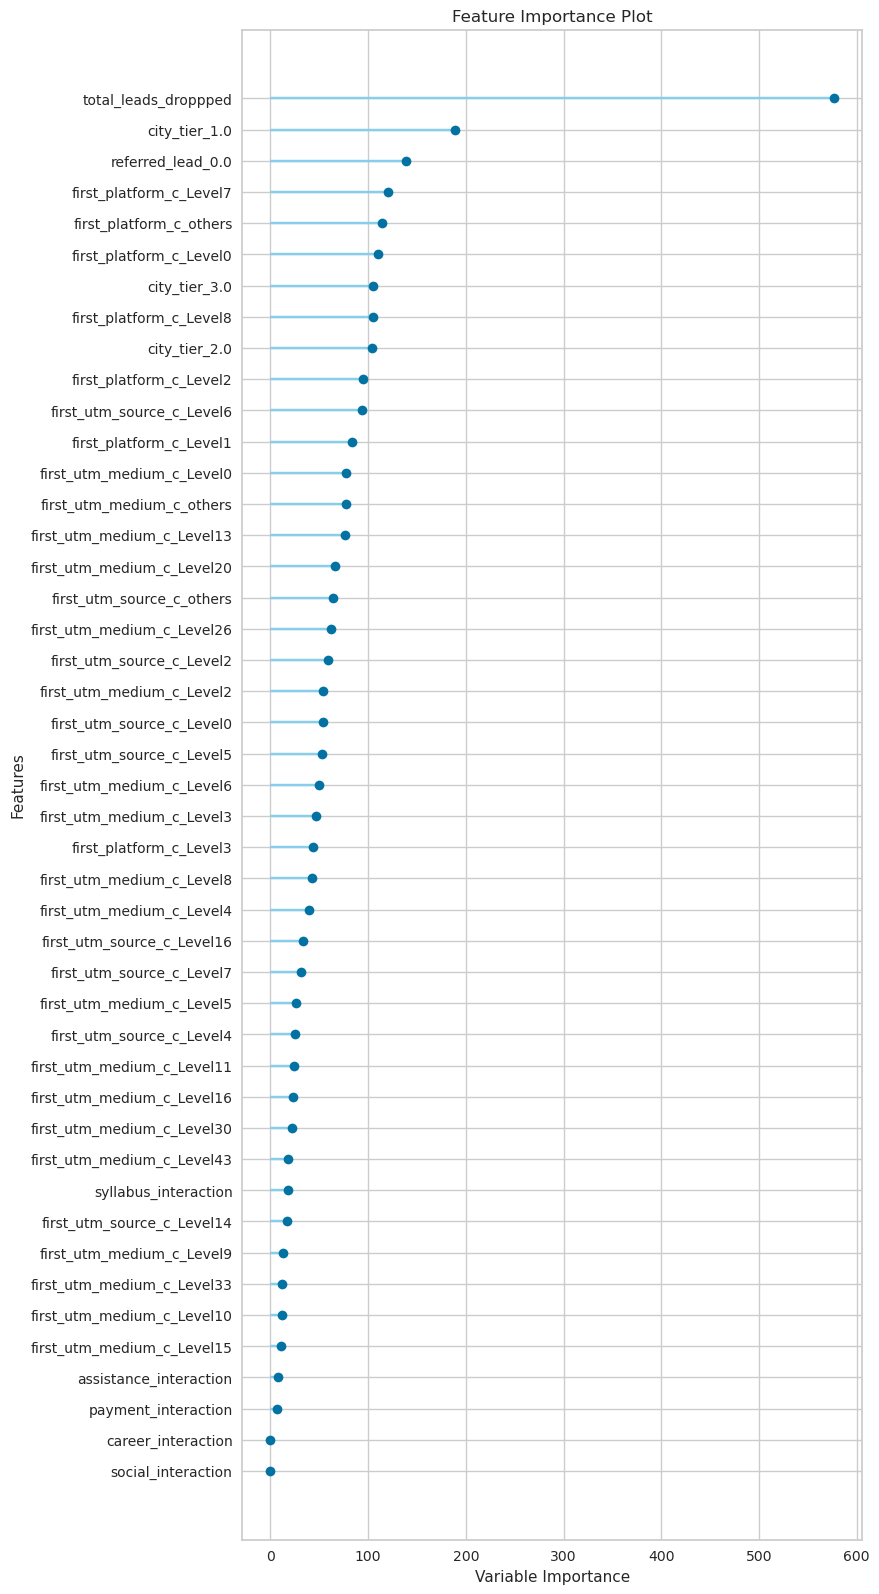

In [27]:
# create feature importance plot
plot_model(lightgbm, plot='feature_all')

In [28]:
lightgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [32]:
dataset_trimmed = encoded_df.drop(['assistance_interaction', 'career_interaction', 'payment_interaction', 'social_interaction', 'syllabus_interaction'], axis=1)

In [33]:
dataset_trimmed.head()

,city_tier_1.0,city_tier_2.0,city_tier_3.0,first_platform_c_Level0,first_platform_c_Level1,first_platform_c_Level2,first_platform_c_Level3,first_platform_c_Level7,first_platform_c_Level8,first_platform_c_others,...,first_utm_source_c_Level16,first_utm_source_c_Level2,first_utm_source_c_Level4,first_utm_source_c_Level5,first_utm_source_c_Level6,first_utm_source_c_Level7,first_utm_source_c_others,total_leads_droppped,referred_lead,app_complete_flag
0,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1.0,0.0,1
1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1.0,0.0,1
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1.0,0.0,1
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,2.0,0.0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1.0,0.0,0


In [37]:
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.

exp_lead_scoring = setup(data =dataset_trimmed , target = 'app_complete_flag', 
                   session_id = 42,fix_imbalance=False,
                   n_jobs=-1,use_gpu=False,
                   log_experiment=True,experiment_name='Lead_scoring_mlflow_experimentation_dropfeatures',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False, normalize=False,
                   transformation=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 41)"
5,Missing Values,False
6,Numeric Features,39
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


2023/01/25 17:12:04 INFO mlflow.tracking.fluent: Experiment with name 'Lead_scoring_mlflow_experimentation_dropfeatures' does not exist. Creating a new experiment.


In [38]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 
best_model = compare_models(fold = 10,exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7387,0.8211,0.8298,0.7036,0.7615,0.4768,0.4847,32.0860
lightgbm,Light Gradient Boosting Machine,0.7387,0.8211,0.8328,0.7026,0.7622,0.4768,0.4854,1.7920
rf,Random Forest Classifier,0.7372,0.8187,0.8246,0.7037,0.7593,0.4739,0.4811,12.6330
et,Extra Trees Classifier,0.7366,0.8178,0.8213,0.7042,0.7582,0.4728,0.4795,15.6290
dt,Decision Tree Classifier,0.7364,0.8170,0.8208,0.7040,0.7579,0.4722,0.4790,0.5600
lr,Logistic Regression,0.7099,0.7842,0.8220,0.6733,0.7403,0.4191,0.4299,1.8350
ridge,Ridge Classifier,0.6995,0.0000,0.7963,0.6690,0.7271,0.3983,0.4058,0.1380
lda,Linear Discriminant Analysis,0.6995,0.7732,0.7963,0.6690,0.7271,0.3983,0.4058,1.1440
nb,Naive Bayes,0.6735,0.7337,0.8567,0.6286,0.7251,0.3455,0.3712,0.1360


In [39]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret
lightgbm_model = create_model('lightgbm')

In [40]:
lightgbm_model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [41]:
!pip install optuna

  Using cached optuna-3.1.0-py3-none-any.whl (365 kB)
  Using cached cmaes-0.9.1-py3-none-any.whl (21 kB)


In [42]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC

import optuna
tuned_lgbm_optuna,tuner_1 = tune_model(lightgbm_model, 
                                   search_library = 'scikit-learn',
                                   fold = 10,
                                   optimize = 'auc',
                                   choose_better = True, 
                                   return_tuner=True)

In [43]:
# Print the final models configuration so that we can use it in the model retraining pipeline 
print(tuned_lgbm_optuna)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [44]:
model_config = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0
}

with mlflow.start_run(run_name='run_LightGB_withoutHPTune', nested=True) as run:
    mlflow.sklearn.log_model(sk_model=tuned_lgbm_optuna,artifact_path="models", registered_model_name='LightGBM')
    mlflow.log_params(model_config)
    mlflow.log_artifacts("/home/MLOps_Assignment/mlruns")

Registered model 'LightGBM' already exists. Creating a new version of this model...
2023/01/25 17:33:17 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LightGBM, version 6
Created version '6' of model 'LightGBM'.
